1.Setup and Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load original dataset
df = pd.read_csv("Hospital_OPD_Queue_Dataset.csv")
df['arrival_time_dt'] = pd.to_datetime(df['arrival_time'], format='%I:%M %p')

# preview
print("First 5 rows:")
print(df.head())


First 5 rows:
   patient_id patient_type arrival_time  waiting_time  service_time  \
0           1       normal      7:01 AM           0.0          9.96   
1           2        staff      7:03 AM           0.0          8.46   
2           3   lab_report      7:09 AM           0.0          6.59   
3           4   lab_report      7:09 AM           0.0          4.57   
4           5       normal      7:10 AM           0.0         17.60   

  assign_doctor     arrival_time_dt  
0          Dr_1 1900-01-01 07:01:00  
1          Dr_2 1900-01-01 07:03:00  
2          Dr_3 1900-01-01 07:09:00  
3          Dr_4 1900-01-01 07:09:00  
4          Dr_5 1900-01-01 07:10:00  


2.Define Simulation Function

In [ ]:
def simulate_scalability(df, num_doctors=5, total_patients=None):

    df_sim = df.copy()
    
    # increase patient count by sampling with replacement if specified
    if total_patients is not None and total_patients > len(df):
        extra_rows = df.sample(total_patients - len(df), replace=True)
        df_sim = pd.concat([df_sim, extra_rows], ignore_index=True)
    
    # assign doctors in round-robin 
    doctors = [f'Dr_{i+1}' for i in range(num_doctors)]
    df_sim['assign_doctor'] = [doctors[i % num_doctors] for i in range(len(df_sim))]
    
    # calculate metrics
    session_hours = (df_sim['arrival_time_dt'].max() - df_sim['arrival_time_dt'].min()).total_seconds() / 3600
    throughput = len(df_sim) / session_hours
    avg_waiting_time = df_sim['waiting_time'].mean()
    total_session_time = session_hours * 60
    doctor_busy_time = df_sim.groupby('assign_doctor')['service_time'].sum()
    doctor_utilization = (doctor_busy_time / total_session_time) * 100
    
    return {
        "patients": len(df_sim),
        "doctors": num_doctors,
        "avg_waiting_time": avg_waiting_time,
        "throughput": throughput,
        "doctor_utilization": doctor_utilization
    }


3.Run Multiple Scenarios

In [ ]:
# scenarios
doctor_counts = [4, 5, 6]
patient_counts = [200, 300, 400]

results = []

for d in doctor_counts:
    for p in patient_counts:
        metrics = simulate_scalability(df, num_doctors=d, total_patients=p)
        results.append(metrics)

# convert to DataFrame
sim_df = pd.DataFrame(results)
sim_df['doctors'] = sim_df['doctors'].astype(str)  #  hue in plots
sim_df['patients'] = sim_df['patients'].astype(int)
sim_df


,patients,doctors,avg_waiting_time,throughput,doctor_utilization
0,200,4,68.683750,40.404040,assign_doctor Dr_1 175.208754 Dr_2 179.8...
1,300,4,67.422200,60.606061,assign_doctor Dr_1 266.107744 Dr_2 266.6...
2,400,4,68.881825,80.808081,assign_doctor Dr_1 364.858586 Dr_2 330.6...
3,200,5,68.683750,40.404040,assign_doctor Dr_1 144.969697 Dr_2 133.7...
4,300,5,66.122067,60.606061,assign_doctor Dr_1 207.535354 Dr_2 206.5...
5,400,5,68.142300,80.808081,assign_doctor Dr_1 283.067340 Dr_2 278.8...
6,200,6,68.683750,40.404040,assign_doctor Dr_1 125.060606 Dr_2 118.1...
7,300,6,70.065333,60.606061,assign_doctor Dr_1 181.205387 Dr_2 189.6...
8,400,6,67.830825,80.808081,assign_doctor Dr_1 235.414141 Dr_2 236.5...


4.Analyze Metrics

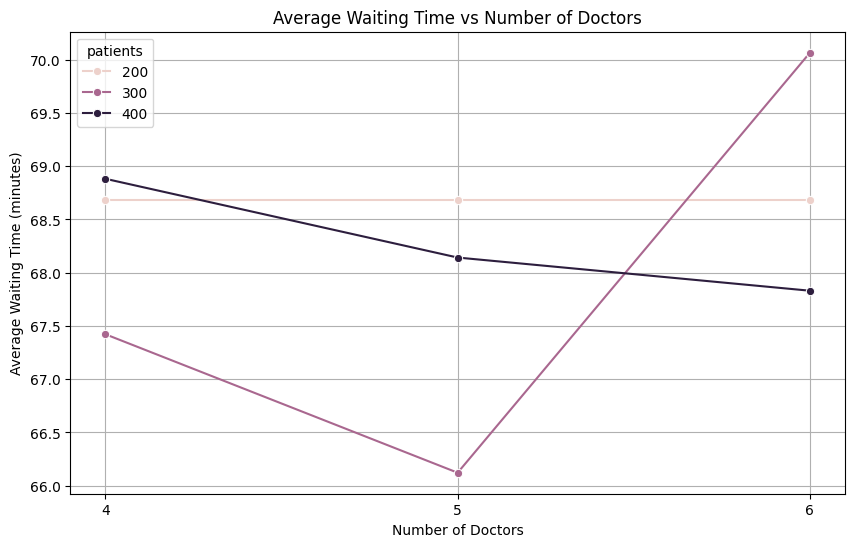

In [32]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sim_df, x='doctors', y='avg_waiting_time', hue='patients', marker='o')
plt.title("Average Waiting Time vs Number of Doctors")
plt.xlabel("Number of Doctors")
plt.ylabel("Average Waiting Time (minutes)")
plt.grid(True)
plt.show()


Throughput vs Patient Count

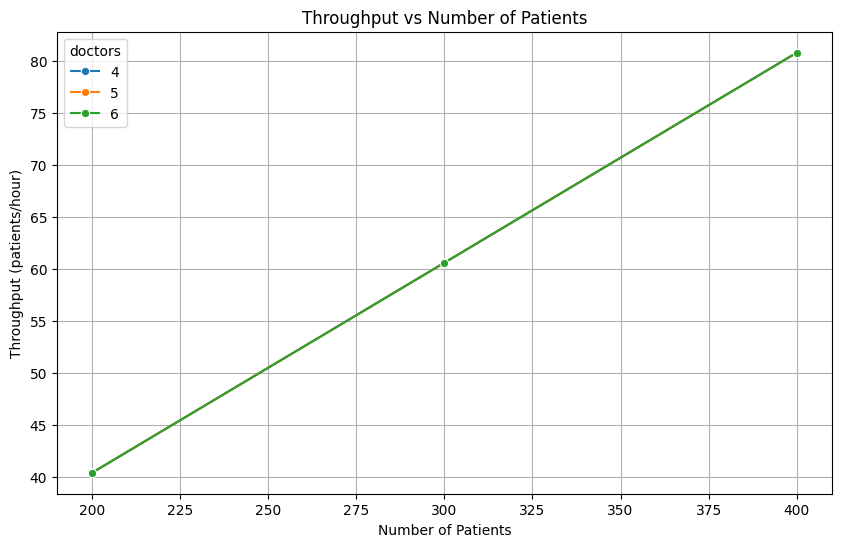

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sim_df, x='patients', y='throughput', hue='doctors', marker='o')
plt.title("Throughput vs Number of Patients")
plt.xlabel("Number of Patients")
plt.ylabel("Throughput (patients/hour)")
plt.grid(True)
plt.show()




Doctor Utilization Distribution

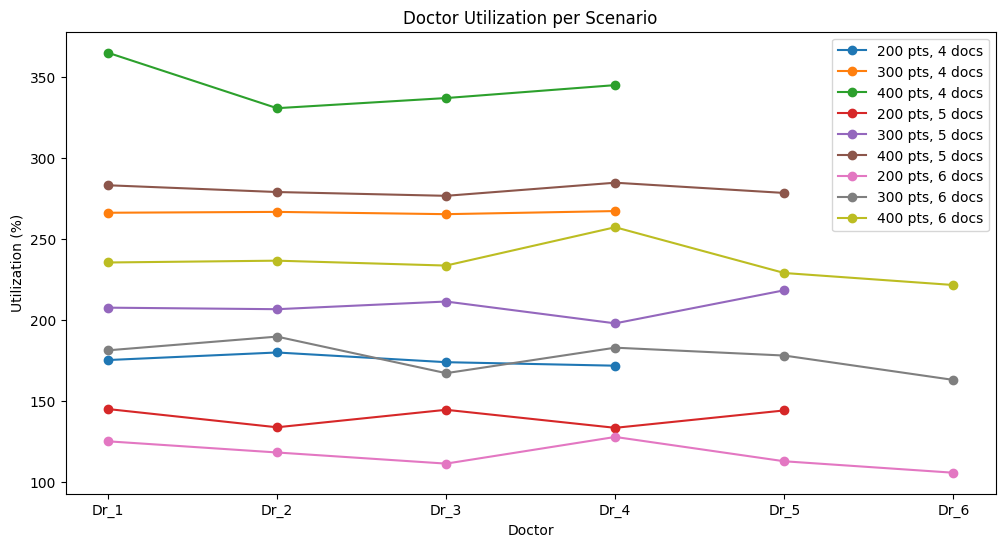

In [34]:
plt.figure(figsize=(12,6))
for idx, row in sim_df.iterrows():
    plt.plot(row['doctor_utilization'].index, row['doctor_utilization'].values, marker='o', label=f"{row['patients']} pts, {row['doctors']} docs")
plt.title("Doctor Utilization per Scenario")
plt.xlabel("Doctor")
plt.ylabel("Utilization (%)")
plt.legend()
plt.show()
